## User Based Collaborative Filtering

In [2]:
import pandas as pd
import numpy as np
import ast
import re
import random

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [3]:
users = pd.read_csv('PA_restaurant_user_with_loc.csv')
print(users.info())
users.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269461 entries, 0 to 269460
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   user_id                269461 non-null  object 
 1   name                   269459 non-null  object 
 2   review_count           269461 non-null  int64  
 3   yelping_since          269461 non-null  object 
 4   useful                 269461 non-null  int64  
 5   funny                  269461 non-null  int64  
 6   cool                   269461 non-null  int64  
 7   elite                  21171 non-null   object 
 8   friends                160194 non-null  object 
 9   fans                   269461 non-null  int64  
 10  average_stars          269461 non-null  float64
 11  compliment_hot         269461 non-null  int64  
 12  compliment_more        269461 non-null  int64  
 13  compliment_profile     269461 non-null  int64  
 14  compliment_cute        269461 non-nu

C:\Users\woowe\AppData\Local\Temp\ipykernel_68\1034717030.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  users = pd.read_csv('PA_restaurant_user_with_loc.csv')


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,"('latitude', 'mean')","('longitude', 'mean')"
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,56,18,232,844,467,467,239,180,39.959457,-75.169912
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,157,251,1847,7054,3131,3131,1521,1946,39.988870,-75.191895
2,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1221,2005-03-14 20:26:35,14953,9940,11211,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",1357,...,361,147,1212,5696,2543,2543,815,323,39.953551,-75.163223


In [4]:
users['num_friends'] = users['friends'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
users = users.drop(columns=['friends'])

In [5]:
user_features_report = ["review_count", "useful", "fans", "average_stars", "compliment_hot", 
                        "num_friends", "('latitude', 'mean')", "('longitude', 'mean')"]

In [6]:
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
profile_matrix = scaler.fit_transform(users[user_features_report])

parsed_profile_matrix = csr_matrix(profile_matrix)

print(parsed_profile_matrix)

  (0, 0)	3.9039989688611403
  (0, 1)	6.200488665413516
  (0, 2)	7.313601850355668
  (0, 3)	0.23733605501434307
  (0, 4)	2.0558427591288977
  (0, 5)	79.64788522658591
  (0, 6)	-0.5340372536399445
  (0, 7)	0.27579719442581896
  (1, 0)	30.66763981895271
  (1, 1)	37.37521528596912
  (1, 2)	86.80520296461627
  (1, 3)	0.07670392340391693
  (1, 4)	9.521804359253903
  (1, 5)	24.454906663893983
  (1, 6)	-0.2636191936907864
  (1, 7)	0.13259732951843048
  (2, 0)	8.44553460937828
  (2, 1)	12.923120240833544
  (2, 2)	37.49327625458557
  (2, 3)	0.18064236150478083
  (2, 4)	14.259978871958934
  (2, 5)	30.838711412134607
  (2, 6)	-0.5883340052165895
  (2, 7)	0.3193671209368935
  (3, 0)	0.5049880177822748
  :	:
  (269457, 7)	-2.046083756952044
  (269458, 0)	-0.23051225104361436
  (269458, 1)	-0.07025971207238434
  (269458, 2)	-0.07903398994651915
  (269458, 3)	-0.7831504281577765
  (269458, 4)	-0.029621374984232063
  (269458, 5)	-0.323002158433466
  (269458, 6)	-0.6382460585506283
  (269458, 7)	0.32431

## Construct user-item interaction data

In [8]:
reviews = pd.read_csv('review_final.csv')
print(reviews.info())
reviews.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836679 entries, 0 to 836678
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   review_id         836679 non-null  object 
 1   user_id           836679 non-null  object 
 2   business_id       836679 non-null  object 
 3   stars             836679 non-null  float64
 4   useful            836679 non-null  int64  
 5   funny             836679 non-null  int64  
 6   cool              836679 non-null  int64  
 7   text              836679 non-null  object 
 8   date              836679 non-null  object 
 9   text_length       836679 non-null  int64  
 10  processed_review  836588 non-null  object 
 11  sum_votes         836679 non-null  int64  
 12  review_age_days   836679 non-null  int64  
 13  review_weight     836679 non-null  float64
 14  weighted_stars    836679 non-null  float64
dtypes: float64(3), int64(6), object(6)
memory usage: 95.8+ MB
None


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length,processed_review,sum_votes,review_age_days,review_weight,weighted_stars
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,101,decide eat aware going take hour beginning end...,0,2369,0.712890,2.138669
1,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,48,wow yummy different delicious favorite lamb cu...,2,3649,0.593757,2.968783
2,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,42,tremendous service big shout douglas complemen...,0,4208,0.548185,2.740924


In [9]:
from datetime import datetime

reviews['date'] = pd.to_datetime(reviews['date'])
print(reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836679 entries, 0 to 836678
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   review_id         836679 non-null  object        
 1   user_id           836679 non-null  object        
 2   business_id       836679 non-null  object        
 3   stars             836679 non-null  float64       
 4   useful            836679 non-null  int64         
 5   funny             836679 non-null  int64         
 6   cool              836679 non-null  int64         
 7   text              836679 non-null  object        
 8   date              836679 non-null  datetime64[ns]
 9   text_length       836679 non-null  int64         
 10  processed_review  836588 non-null  object        
 11  sum_votes         836679 non-null  int64         
 12  review_age_days   836679 non-null  int64         
 13  review_weight     836679 non-null  float64       
 14  weig

In [10]:
reviews['interaction'] = reviews['stars'].apply(lambda x: 1 if x>=3 else 0)
interaction_df = reviews[['user_id', 'business_id',
                            'stars', 'interaction', 'date']]
interaction_df.head(2)

,user_id,business_id,stars,interaction,date
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,1,2018-07-07 22:09:11
1,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,2015-01-04 00:01:03


## Construct user-based collaborative filtering model

In [12]:
# Leave-one-out train-test split 
train_df = interaction_df[interaction_df['date'] < '2021-01-01']
test_df = interaction_df[interaction_df['date'] >= '2021-01-01']

In [13]:
print('train set size:', len(train_df))
print('test set size:', len(test_df))

train set size: 765907
test set size: 70772


In [14]:
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: user-item matrix from train_df
user_encoder = {uid: idx for idx, uid in enumerate(train_df['user_id'].unique())}
item_encoder = {iid: idx for idx, iid in enumerate(train_df['business_id'].unique())}
user_decoder = {idx: uid for uid, idx in user_encoder.items()}

train_df['user_idx'] = train_df['user_id'].map(user_encoder)
train_df['item_idx'] = train_df['business_id'].map(item_encoder)

user_item_matrix_sparse = csr_matrix((train_df['stars'], (train_df['user_idx'], train_df['item_idx'])))


C:\Users\woowe\AppData\Local\Temp\ipykernel_68\399367661.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['user_idx'] = train_df['user_id'].map(user_encoder)
C:\Users\woowe\AppData\Local\Temp\ipykernel_68\399367661.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['item_idx'] = train_df['business_id'].map(item_encoder)


In [15]:
import pickle

with open('user_encoder.pkl', 'wb') as f:
    pickle.dump(user_encoder, f)
    
with open('item_encoder.pkl', 'wb') as f:
    pickle.dump(item_encoder, f)
    
with open('user_decoder.pkl', 'wb') as f:
    pickle.dump(user_decoder, f)

In [16]:
# Align users
users = users[users['user_id'].isin(user_encoder)].copy()
users = users.set_index('user_id').loc[user_encoder.keys()].reset_index()

scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(users[user_features_report])
user_features_sparse = csr_matrix(user_features_scaled)


In [17]:
users.to_csv("users_df.csv", index=False)

In [18]:
hybrid_user_matrix = hstack([user_item_matrix_sparse, user_features_sparse])

In [19]:
from scipy import sparse

sparse.save_npz("cf_matrix.npz", hybrid_user_matrix)

In [20]:
def get_hybrid_userbased_cf(user_id, k=10, visualize=True):
    if user_id not in user_encoder:
        return pd.DataFrame(columns=['business_id', 'predicted_score'])

    user_idx = user_encoder[user_id]
    query_vector = hybrid_user_matrix[user_idx].reshape(1, -1)

    similarity_scores = cosine_similarity(query_vector, hybrid_user_matrix).flatten()
    similarity_scores[user_idx] = 0  # remove self-similarity

    # Get top-k similar users
    top_k_indices = np.argsort(similarity_scores)[::-1][:k]
    top_k_user_ids = [user_decoder[i] for i in top_k_indices]
    top_k_similarities = similarity_scores[top_k_indices]

    # Get ratings from these similar users
    sim_user_ratings = train_df[train_df['user_id'].isin(top_k_user_ids)].copy()
    sim_score_dict = dict(zip(top_k_user_ids, top_k_similarities))
    sim_user_ratings['weight'] = sim_user_ratings['user_id'].map(sim_score_dict)
    sim_user_ratings['weighted_ratings'] = sim_user_ratings['stars'] * sim_user_ratings['weight']

    # Aggregate predictions
    agg_df = sim_user_ratings.groupby('business_id').agg(
        predicted_score=('weighted_ratings', 'sum'),
        total_weight=('weight', 'sum')
    )

    agg_df['predicted_score'] = agg_df['predicted_score'] / agg_df['total_weight']
    
    # Select top-k
    top_recs = agg_df.sort_values(by='predicted_score', ascending=False).head(k).reset_index()

    
    return top_recs[['business_id', 'predicted_score']]


In [21]:
test_df.head(2)

,user_id,business_id,stars,interaction,date
42877,rYvWv-Ny16b1lMcw1IP7JQ,jfIwOEXcVRyhZjM4ISOh4g,1.0,0,2021-01-02 00:19:00
43178,2ntnbUia9Bna62W0fqNcxg,S-VD26LE_LeJNx5nASk_pw,5.0,1,2021-01-26 18:01:45


### Evaluation - Hit@10

In [23]:
random.seed(42) 

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def hits_at_k(user_id, test_df, recommend_func, k=10):
    # true_item = test_df.loc[test_df['user_id'] == user_id]['business_id'].iloc[0]
    true_items = test_df[(test_df['user_id'] == user_id) &
                         # Hit rate should consider if the user liked the restaurant
                         (test_df['stars'] >= 3)
                         ]['business_id'].tolist()
    recommended = recommend_func(user_id, k)

    recommended_items = recommended['business_id'].tolist()

    return int(any(item in recommended_items for item in true_items))

def plot_hit_rate_vs_users(test_df, max_users, step):
    # Step 1: Get users sorted by interaction count descending
    user_interaction_counts = (
        test_df.groupby('user_id')
        .size()
        .sort_values(ascending=False)
    )
    sorted_users = user_interaction_counts.index.tolist()

    # Step 2: Loop with cumulative hit calculation
    hit_rates = []
    total_hits = 0
    evaluated_users = 0

    for i in range(step, max_users + 1, step):
        current_batch = sorted_users[evaluated_users:i]
        hits_in_batch = sum(
            hits_at_k(user, test_df, get_hybrid_userbased_cf, k=10)
            for user in current_batch
        )
        total_hits += hits_in_batch
        evaluated_users = i
        hit_rate = total_hits / evaluated_users
        hit_rates.append(hit_rate)

    # Step 3: Plot
    n_users_range = list(range(step, max_users + 1, step))
    plt.figure(figsize=(10, 6))
    plt.plot(n_users_range, hit_rates, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Top Users (by Interactions)")
    plt.ylabel("Hit Rate@10")
    plt.title("Hit Rate vs. Number of Included Users")
    plt.grid(True)
    plt.show()

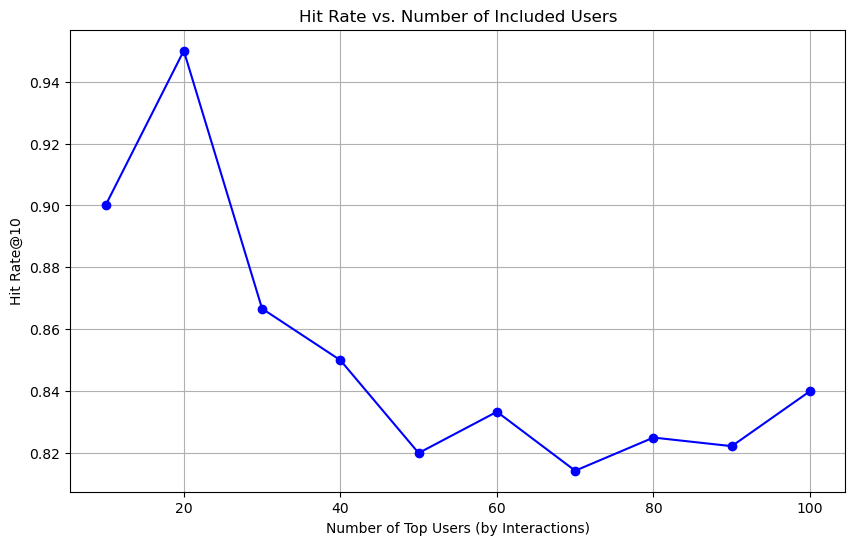

In [25]:
plot_hit_rate_vs_users(train_df, max_users=100, step=10)

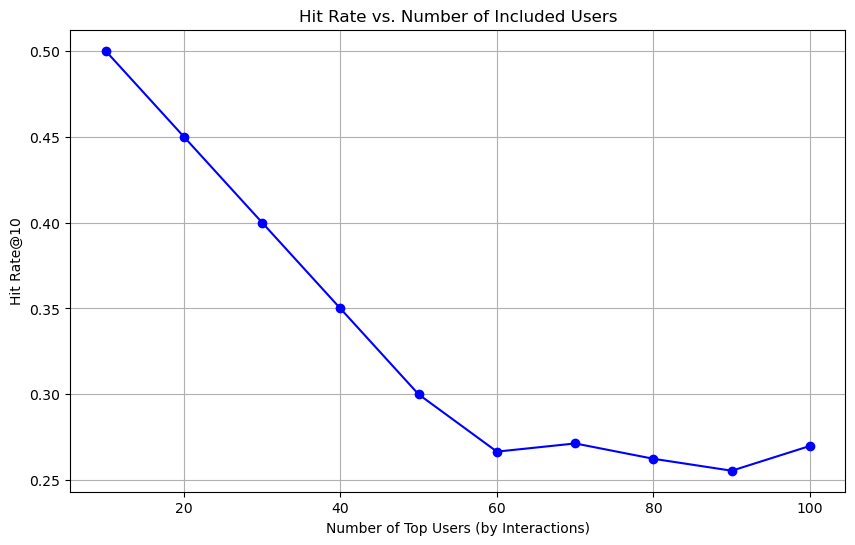

In [26]:
plot_hit_rate_vs_users(test_df, max_users=100, step=10)

In [27]:
def plot_hit_rate_vs_users_random(test_df, max_users, step):
    # Step 1: Get unique users and shuffle
    unique_users = test_df['user_id'].unique().tolist()
    random.shuffle(unique_users)

    # Ensure we don't exceed the available number of users
    max_users = min(max_users, len(unique_users))

    # Step 2: Loop with cumulative hit calculation
    hit_rates = []
    total_hits = 0
    evaluated_users = 0

    for i in range(step, max_users + 1, step):
        current_batch = unique_users[evaluated_users:i]
        hits_in_batch = sum(
            hits_at_k(user, test_df, get_hybrid_userbased_cf, k=10)
            for user in current_batch
        )
        total_hits += hits_in_batch
        evaluated_users = i
        hit_rate = total_hits / evaluated_users
        hit_rates.append(hit_rate)

    # Step 3: Plot
    n_users_range = list(range(step, max_users + 1, step))
    plt.figure(figsize=(10, 6))
    plt.plot(n_users_range, hit_rates, marker='o', linestyle='-', color='g')
    plt.xlabel("Number of Random Users")
    plt.ylabel("Hit Rate@10")
    plt.title("Hit Rate vs. Number of Randomly Selected Users")
    plt.grid(True)
    plt.show()

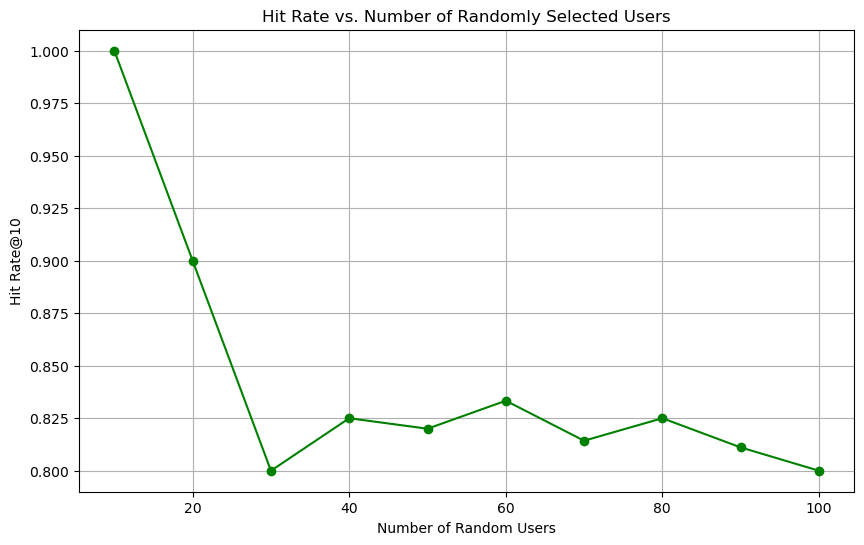

In [28]:
plot_hit_rate_vs_users_random(train_df, 100, 10)

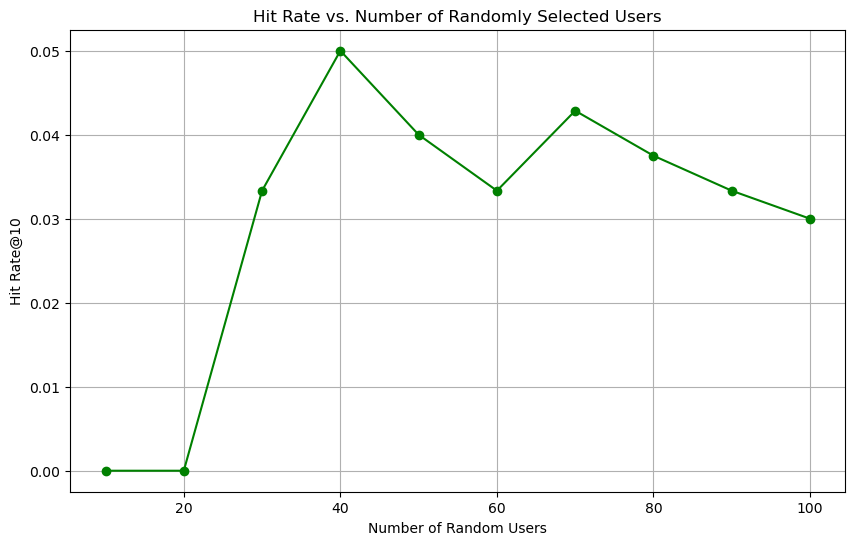

In [29]:
plot_hit_rate_vs_users_random(test_df, 100, 10)

### Evaluation - NDCG@10

In [31]:
def dcg_at_k(relevance_scores, k):
    relevance_scores = np.asarray(relevance_scores)[:k]
    return np.sum((2**relevance_scores - 1) / np.log2(np.arange(2, relevance_scores.size + 2))) if relevance_scores.size else 0.


def ndcg_at_k(relevance_scores, k):
    dcg = dcg_at_k(relevance_scores, k)
    idcg = dcg_at_k(sorted(relevance_scores, reverse=True), k)
    return dcg / idcg if idcg > 0 else 0.

In [32]:
def get_ndcg_at_k(user, test_df, k=10):
    recommendations = get_hybrid_userbased_cf(user, k)
    
    if recommendations.empty:
        return None
    
    #Get true items
    true_items = test_df[test_df['user_id'] == user][['business_id', 'stars']]
    
    recommendations = recommendations[['business_id', 'predicted_score']]
    recommendations = recommendations.merge(true_items, on="business_id", how="left")
    
    recommendations = recommendations.sort_values(
        "predicted_score", ascending=False)
    
    if recommendations["stars"].count() >= 2:
        relevance_scores = recommendations["stars"].dropna().tolist()
        ndcg = ndcg_at_k(relevance_scores, k)
        return ndcg
    else:
        return None

In [33]:
def ndcg_evaluation_top_n_users(test_df, n=1000, k=10): 
    top_users = (
    test_df
    .groupby('user_id')
    .size()
    .sort_values(ascending=False)
    .head(n)
    .index.tolist()
    )

    ndcg_scores = []
    for user in top_users:
        ndcg = get_ndcg_at_k(user, test_df, k)
        if ndcg is not None:
            ndcg_scores.append(ndcg)

    print("Mean NDCG@10: ", np.mean(ndcg_scores))

In [34]:
ndcg_evaluation_top_n_users(train_df, n=1000, k=10)

Mean NDCG@10:  0.9136760107129978


In [35]:
ndcg_evaluation_top_n_users(test_df, n=1000, k=10)

Mean NDCG@10:  0.9310974515367878


In [36]:
def ndcg_evaluation_random_n_users(test_df, n=1000, k=10): 
    unique_users = test_df['user_id'].unique().tolist()

    sampled_users = np.random.choice(unique_users, size=min(n, len(unique_users)), replace=False)

    ndcg_scores = []
    for user in sampled_users:
        ndcg = get_ndcg_at_k(user, test_df, k)
        if ndcg is not None:
            ndcg_scores.append(ndcg)

    print("Mean NDCG@10: ", np.mean(ndcg_scores))

In [37]:
ndcg_evaluation_random_n_users(train_df, n=1000, k=10)

Mean NDCG@10:  0.9637195354480994


In [38]:
ndcg_evaluation_random_n_users(test_df, n=1000, k=10)

Mean NDCG@10:  nan


C:\Users\woowe\anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\woowe\anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [39]:
# Unique users in each set
train_users = set(train_df['user_id'].unique())
test_users = set(test_df['user_id'].unique())

# Uers who are in both train and test
overlapping_users = test_users.intersection(train_users)

# Cold-start users: in test but not in train
cold_start_users = test_users.difference(train_users)

# Output
print(f"Total test users       : {len(test_users)}")
print(f"Users also in train    : {len(overlapping_users)}")
print(f"Cold-start test users  : {len(cold_start_users)}")


Total test users       : 37230
Users also in train    : 15688
Cold-start test users  : 21542


## Get Recommendations

In [41]:
recommendations = get_hybrid_userbased_cf('mh_-eMZ6K5RLWhZyISBhwA', k=10)
recommendations

,business_id,predicted_score
0,WL-0PLW5IzdnyUHGmiOrgQ,5.0
1,xdG_RW_QsAGJbXp46M_V8w,5.0
2,-rwfGlw6T5czqQO4uZGWYw,5.0
3,sYgyAxvuDP1799oiGXqE_A,5.0
4,YjLMWlHoBJHtYMLdFXfvVg,5.0
5,gpYBhnTk4KzvvH83TsZiQg,5.0
6,NQ01WqVX0tojNHKn-0sFww,5.0
7,Lp7o7wv0-QtupZeZP0QcMg,5.0
8,I8IPPZvEPdb_xG0nGIMyjA,5.0
9,HDdfUbox_zCbiyoNMhSVzg,5.0
